In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter


In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=8)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Single")
parser.add_argument("--Mach", type=float, default=0.1)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach= args["Mach"]


ICH FUNKTIONIERE MIT PULLEN


In [3]:
print(Precision)
lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float32 if Precision == "Single" else torch.float64)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))
tensor=torch.tensor(1)
print(tensor.dtype)

# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)

print()
streaming = lt.StandardStreaming(lattice)
simulation = lt.SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)
print(flow.units.convert_velocity_to_pu(simulation.lattice.u(simulation.f)))

Single
882.1262326748672
torch.int64

tensor([[[[-9.5611e-03, -2.8316e-02, -4.5982e-02,  ..., -8.6027e-02,
           -9.3345e-02, -9.7075e-02],
          [-9.1935e-03, -2.7228e-02, -4.4215e-02,  ..., -8.2721e-02,
           -8.9758e-02, -9.3345e-02],
          [-8.4728e-03, -2.5093e-02, -4.0749e-02,  ..., -7.6236e-02,
           -8.2721e-02, -8.6027e-02],
          ...,
          [-4.5291e-03, -1.3413e-02, -2.1781e-02,  ..., -4.0749e-02,
           -4.4215e-02, -4.5982e-02],
          [-2.7889e-03, -8.2593e-03, -1.3413e-02,  ..., -2.5093e-02,
           -2.7227e-02, -2.8316e-02],
          [-9.4173e-04, -2.7889e-03, -4.5290e-03,  ..., -8.4729e-03,
           -9.1936e-03, -9.5612e-03]],

         [[-2.8316e-02, -8.3859e-02, -1.3618e-01,  ..., -2.5478e-01,
           -2.7645e-01, -2.8750e-01],
          [-2.7228e-02, -8.0637e-02, -1.3095e-01,  ..., -2.4498e-01,
           -2.6582e-01, -2.7645e-01],
          [-2.5093e-02, -7.4315e-02, -1.2068e-01,  ..., -2.2578e-01,
           -2.4498e-

In [4]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/20)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_TGV(lattice, flow)
Energyspectrum= lt.EnergySpectrum(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2= lt.ObservableReporter(Dissipation_TGV, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
reporter3=lt.ObservableReporter(Energyspectrum, interval=interval_out, out=None)
simulation.reporters.append(reporter3)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_TGV
steps     time     EnergySpectrum


/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
#print("Performance in MLUPS:", mlups)


In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
print(nmax,dt)
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
#dissipationEkin=np.array([energy[:,1],-1/(np.pi*2)**3*np.gradient(energy[:,2],energy[:,1])])

dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*0.5)**3])

dissipationEns=np.array([dissipation[:,1],1/(0.5*np.pi)**3*dissipation[:,3]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)

883 0.011336246026463862


[31.0062809  31.01969528 30.96588898 30.97402382 30.92746925 30.92701721
 30.88963509 30.88031769 30.85099602 30.83509064 30.81089973 30.79162598
 30.76951218 30.74930573 30.72766495 30.70705605 30.68623734 30.66410446
 30.64552498 30.62033653 30.60531998 30.57615852 30.56503105 30.53230858
 30.52400589 30.48936462 30.48190308 30.44752884 30.43875885 30.40659523
 30.39499855 30.36598587 30.35125923 30.32510757 30.3079586  30.2836895
 30.26516533 30.24179649 30.22266579 30.1997509  30.18009758 30.15786171
 30.13720512 30.11623001 30.09393311 30.07478523 30.05044174 30.03325653
 30.00706863 29.99132729 29.96410179 29.94882584 29.92163277 29.90578461
 29.87953949 29.86240578 29.83755302 29.81895065 29.79540253 29.7755661
 29.75291824 29.73230362 29.71005249 29.68911171 29.66693497 29.64585495
 29.62373924 29.60243416 29.58060837 29.5588398  29.53758049 29.51516342
 29.49456978 29.47151566 29.45144272 29.42793465 29.4080658  29.38438606
 29.36436081 29.34077072 29.32032776 29.29698753 29.2

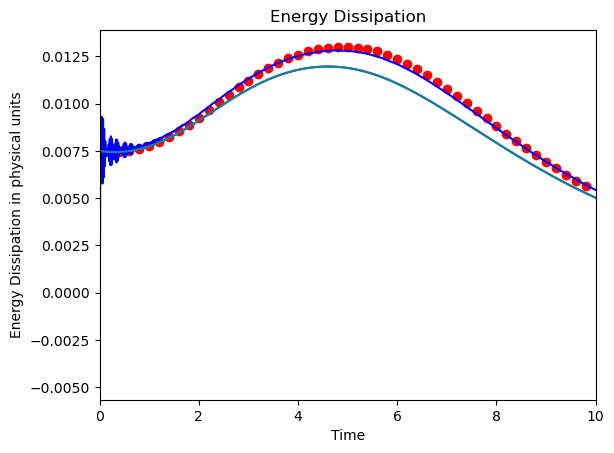

In [7]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(64*energy[:,2])

plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
#plt.plot(energy[:,1],energy[:,2]*64)
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()

In [8]:
energy=np.array(simulation.reporters[2].out)
print(energy)

[[0.00000000e+00 0.00000000e+00 6.51279837e-02 3.55549678e-02
  1.07066389e-02 6.34234026e-03]
 [1.00000000e+00 1.13362460e-02 6.51530549e-02 3.55724618e-02
  1.07118012e-02 6.34536613e-03]
 [2.00000000e+00 2.26724921e-02 6.50367737e-02 3.55132520e-02
  1.06936488e-02 6.33458700e-03]
 ...
 [8.80000000e+02 9.97589650e+00 1.07081123e-02 9.46185738e-03
  3.29860812e-03 1.39427755e-03]
 [8.81000000e+02 9.98723275e+00 1.06879901e-02 9.43658873e-03
  3.28956684e-03 1.39065506e-03]
 [8.82000000e+02 9.99856900e+00 1.06676370e-02 9.41160694e-03
  3.28059960e-03 1.38705864e-03]]


(883, 6)
[2.         0.02267249 0.06503677 0.03551325 0.01069365 0.00633459]


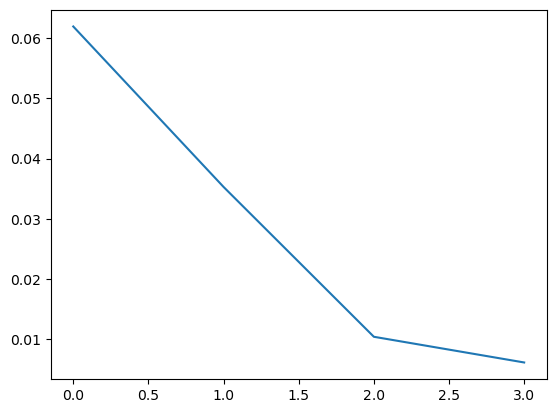

In [9]:
plt.plot(energy[50,2:])
print(energy.shape)
print(energy[2,:])